## A Deep Reinforcement Learning Algorithm Based on Push-Relabel to Optimizing Max Flow Problem


### Benchmark Instance Info:

c Mesh Graph
c 10 Rows, 12 columns, capacities in range [0, 100] (seed: 18247)
p max 122 350
n 1 s
n 122 t

### INPUTS:

There are 5 inputs you are supposed to give at first:
3 inputs associated with the algorithm as follows:

In [84]:
n_neurons=12   # The number of neurons in each layer of neural network: Totally we have 4 layers (2 hidden)

perc_neigb=0.3  #Considered percentage of "max_neighbors" in the network. It should be between 0 and 1.

#AND The total numbers of optimum you want the algorithm finds:

total_optimum= 23 #for this benchmark, 23 optimum points need around 50,000 steps (each around 2200 steps)

####  And 2 inputs are related to the benchmark instance (located in your users folder)

In [70]:
#Important: Source has to be Node 0: so modify the instance in this way
import networkx as nx

#1: name of the benchmark instance file
G = nx.DiGraph()

G = nx.read_weighted_edgelist("Wash_Mesh_r10_co12_c100_1 corrected.txt",create_using=nx.DiGraph(), nodetype = int)

#2: source (start), sink (goal) and number of nodes (n_nodes):

goal=121
start=0
n_nodes=122

In [71]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import pylab as plt
import pandas as pd
from numpy import random
from scipy import stats


from collections import deque
import random
import time
from scipy.sparse import coo_matrix

import tensorflow as tf
from tensorflow import keras

In [72]:
tf.__version__

'2.4.0'

In [73]:
keras.__version__

'2.4.0'

In [74]:
weight=nx.get_edge_attributes(G,'weight')

#A test: : answer=300
weight[0,6]

300.0

<Figure size 432x288 with 0 Axes>

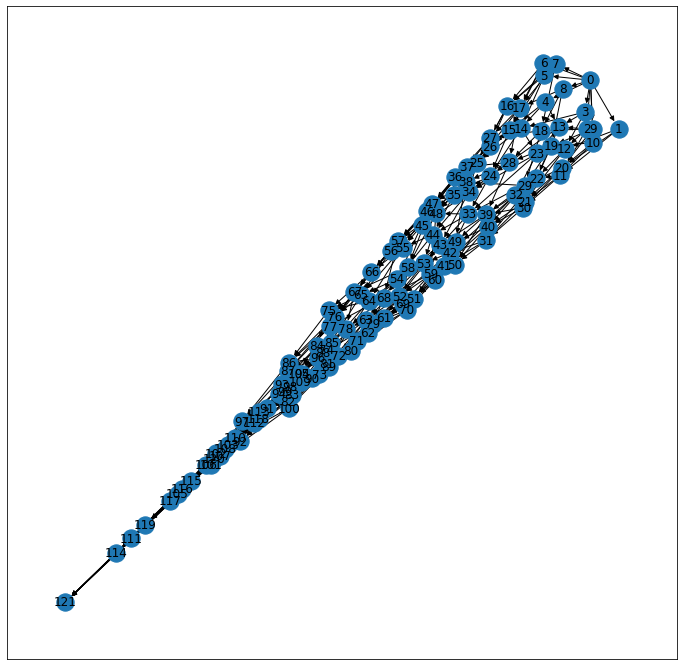

In [75]:
#Looking at the Network

plt.figure(1)
weight = nx.get_edge_attributes(G,'weight')
pos=nx.spring_layout(G)
#nx.draw_circular(G)
plt.figure(3,figsize=(12,12)) 
nx.draw_networkx(G,pos)
#nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()
#nx.draw_networkx(G, with_labels=True)


In [76]:
#edge_list and #labels:

edge_list=G.edges(data = False)
SIZE_MATRIX=7
#edge_list

labels=np.zeros((n_nodes,1))
for i in range(1,n_nodes):
    labels[i]=nx.shortest_path_length(G, source=i, target=goal)
labels[0]=n_nodes



In [82]:
#The input of NN is the max possible neighbors or percentage of it:

#finding the node with max neigbors

max_neighbors=0
dist_neighbors=[]
for i in range(n_nodes):
    add=0
    neigbor=G.neighbors(i)
    for j in neigbor:
        add+=1
    dist_neighbors.append(add)
    if add>max_neighbors:
        max_neighbors=add

print("max_neighbors=",max_neighbors)

max_neighbors= 10


mean= 2.8688524590163933
median= 3.0
mode= 3 count of mode is 110


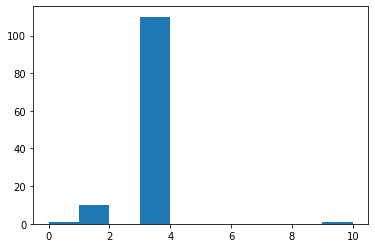

In [83]:
# Looking at the distribution of the neighbors

plt.hist(dist_neighbors)

print("mean=",np.mean(dist_neighbors))
print("median=",np.median(dist_neighbors))

mode= stats.mode(dist_neighbors)
print("mode=",int(mode[0]),"count of mode is",int(mode[1]))


Features (length in parentheses):

	[Number of neighbors of selected active node (1),

	Excess of selected active node (1),
	Label of selected active node (1),

	Excess of “admissible” neighbors (to the lengths of perc_neigb*max_neighbors: label-ordered),
	
     Capacity of “admissible” neighbors (to the lengths of perc_neigb*max_neighbors: label-ordered),
]

Total lengths=3+2* (perc_neigb*max_neighbors)


In [85]:

#Considering percentage of "max_neighbors"

max_neighbors=int(np.round(perc_neigb*max_neighbors))

print("max_considering_neighbors=",max_neighbors)
print("input",3+2*max_neighbors)

max_considering_neighbors= 3
input 9


In [86]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Lambda
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LeakyReLU
    
learning_rate = 0.005
tau = .125
inputs=3+2*max_neighbors

output=1 #all nodes can be selected except source and sink

def build_model(state):
    model = Sequential()
    model.add(Dense(n_neurons,input_shape=(1,inputs), activation=LeakyReLU(alpha=0.1)))
    model.add(Dense(n_neurons, activation=LeakyReLU(alpha=0.1)))
    model.add(Dense(n_neurons, activation=LeakyReLU(alpha=0.1)))
    model.add(Dense(output, activation='relu'))


    model.compile(loss='mean_squared_error',
            optimizer='adam',metrics=['accuracy'])
    return model

In [87]:
#run once: NN1

state=np.zeros((1,2*n_nodes))

local_state=np.zeros((1,inputs))

weight_copy=weight.copy()
flow=coo_matrix((n_nodes,n_nodes)).toarray()

#pre-process:

for edge in G.edges(): #check edge list
    if edge[0]==0:  #if it emanates from source
        flow[0,edge[1]]=weight_copy[0,edge[1]]  #push all flows from source
              
#Updating Excess and the active nodes
active_nodes=[]
excess=np.zeros((n_nodes,1))

for i in range (1,n_nodes):
        excess[i]=flow[:,i].sum()-flow[i,:].sum()
        if excess[i]>0:
            active_nodes.append(i)

#for example put one in active node:
action=int(np.random.choice(active_nodes,1))

direct=G.neighbors(action) #it is not an array so we have to make an array:

all_neighbors=[]
all_neighbors_labels=[]
for i in direct:
    if labels[action]==labels[i]+1:
        all_neighbors.append(i)
        all_neighbors_labels.append(int(labels[i]))

n_neighbors=len(all_neighbors)
local_state[0,0]=n_neighbors

#sort all_neighbors based on labels:
merge_neighbors=np.stack([all_neighbors,all_neighbors_labels])
merge_neighbors=merge_neighbors.T
merge_neighbors_sorted=merge_neighbors[np.argsort(merge_neighbors[:, 1])]

length_tmt=len(all_neighbors)
range_loop=min(length_tmt,max_neighbors) #since we have sparse matrix, we do not need to calculate all

j=0
for i in range(range_loop):
    j+=1
    local_state[0,2+j]=excess[merge_neighbors_sorted[i,0]]
    #local_state[0,max_neighbors+2+j]=labels[merge_neighbors_sorted[i,0]]
    local_state[0,max_neighbors+2+j]=weight_copy[action,merge_neighbors_sorted[i,0]]
    
local_state[0,1]=excess[action]
local_state[0,2]=labels[action]

In [88]:
NN1 = build_model(local_state)
Target_NN1 = build_model(local_state)

In [89]:
NN1.predict(local_state)

array([[39.456387]], dtype=float32)

In [90]:
NN1.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 1, 12)             120       
_________________________________________________________________
dense_149 (Dense)            (None, 1, 12)             156       
_________________________________________________________________
dense_150 (Dense)            (None, 1, 12)             156       
_________________________________________________________________
dense_151 (Dense)            (None, 1, 1)              13        
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


RL Algorithm:


In [91]:
#RL_based Algorithm:


start_time_total = time.time()

n_optimum=0

n_steps=-1
opt_steps=[]
solutions=[]

replay=1
memory = deque(maxlen=replay) # double-ended queue; acts like list, but elements can be added/removed from either end
mem_iter=0 #for memory deque steps

gamma = 0.95 # decay or discount rate: enables agent to take into account future actions in addition to the immediate ones, but discounted at this rate

weight_copy=weight.copy()
labels_copy=labels.copy()

decisions=[]
no_more_active_nodes=[start,goal]    #The nodes that could not be active nodes anymore

flow=coo_matrix((n_nodes,n_nodes)).toarray()

ziter=0   #It is just a measure for NN to see howmany zero predictions will it give finally (less the better)

epsilon = 1 # exploration rate: how much to act randomly; more initially than later due to epsilon decay
epsilon_decay = 0.95 # decrease number of random explorations as the agent's performance (hopefully) improves over time
epsilon_min = 0.01 # minimum amount of random exploration permitted

opt_best=0. #initial opt_best

#PREPROCESSING: pre-push from the source:
for edge in G.edges(): #check edge list
    if edge[0]==0:  #if it emanates from source
        flow[0,edge[1]]=weight_copy[0,edge[1]]  #push all flows from source
        
n_epochs=20 #Training epochs
        
#Updating Excess and the active nodes
active_nodes=[]
excess=np.zeros((n_nodes,1))

for i in range (1,n_nodes):
        excess[i]=flow[:,i].sum()-flow[i,:].sum()
        if excess[i]>0:
            active_nodes.append(i)
excess[0]=0

start_time_optimal = time.time()

#while len(active_nodes)!=0:
while n_optimum<total_optimum:

    n_steps+=1

    
    if n_steps % 500 == 0:
        print("---------------------step=",n_steps,"----------------------")

    #print("----------------step=",n_steps,"------------------")

    
    n_active_nodes=len(active_nodes)

    inputmatrixNN1=np.zeros((n_active_nodes, inputs))
    
    j=0   
    for a in active_nodes:

        local_state=np.zeros((1,inputs))


        direct_action=G.neighbors(a) #it is not an array so we have to make an array:
        all_neighbors=[]
        all_neighbors_labels=[]
        for i in direct_action:
            if labels[a]==labels[i]+1:
                all_neighbors.append(i)
                all_neighbors_labels.append(int(labels[i]))

        
        n_neighbors=len(all_neighbors)
        local_state[0,0]=n_neighbors

        #sort all_neighbors based on labels:
        merge_neighbors=np.stack([all_neighbors,all_neighbors_labels])
        merge_neighbors=merge_neighbors.T
        merge_neighbors_sorted=merge_neighbors[np.argsort(merge_neighbors[:, 1])]
               
        length_tmt=len(all_neighbors)
        range_loop=min(length_tmt,max_neighbors) #since we have sparse matrix, we do not need to calculate all    
            
        z=0
        for i in range(range_loop):
            z+=1
            #local_state[0,z]=merge_neighbors_sorted[i,0]
            local_state[0,2+z]=excess[merge_neighbors_sorted[i,0]]
            #local_state[0,max_neighbors+2+z]=labels[merge_neighbors_sorted[i,0]]
            local_state[0,max_neighbors+2+z]=weight_copy[a,merge_neighbors_sorted[i,0]]

        local_state[0,1]=excess[a]
        local_state[0,2]=labels[a]

        inputmatrixNN1[j]=local_state
        j+=1

        #make prediction"

    if np.random.rand() > epsilon: #just the first round is random

        predictionNN1=NN1.predict(inputmatrixNN1)
        
        if np.sum(predictionNN1)==0:
            ziter+=1
            action=int(np.random.choice(active_nodes,1))
            actiontarget=0
        else:
            action=np.argmax(predictionNN1) #the max probability is the action
            action=active_nodes[action]
            actiontarget=np.max(predictionNN1) #the max achieved

    else:
        action=int(np.random.choice(active_nodes,1))


    direct=G.neighbors(action) #it is not an array so we have to make an array:
    directneigbor=[]
    for i in direct:
        directneigbor.append(i) #so we make an array that contains the neigbors of actions
    
    neigb=nx.all_neighbors(G, action) #ALL NEIGHBORS

    neigbor=[]
    for i in neigb:
        neigbor.append(i) #so we make an array that contains the neigbors of actions
    valid=0 # to see if we can find a destination or not:

    destination=[]
    reward=[]
    d=-1
    for edge in neigbor: #Loop number 
        #destination=edge
        destination_temp=edge

        push_back=0

        if labels_copy[action]-labels_copy[destination_temp]==1: 

            #finding the adjacent of selected active node and
            
            if destination_temp in directneigbor and min(int(excess[action]),weight_copy[action,destination_temp])!=0:
                d+=1
                destination.append(destination_temp)
                rewardtemp=min(int(excess[action]),weight_copy[action,destination_temp])
                reward.append(rewardtemp)
                
                flow[action,destination_temp]=flow[action,destination_temp]+rewardtemp #flow is updated
                weight_copy[action,destination_temp]=weight_copy[action,destination_temp]-rewardtemp   #the weight is updated
                valid=1 #means we could find a destination
                decisions.append([action,destination_temp])
                decisions.append(rewardtemp)
                
                #Updating excess since we want to continue the destinations:
                excess[action]=flow[:,action].sum()-flow[action,:].sum()
            
            elif flow[destination_temp,action]>0:
                d+=1
                destination.append(destination_temp)
                push_back=1 #we know that we push_back
                rewardtemp=min(int(excess[action]),flow[destination_temp,action])
                reward.append(-rewardtemp) #negative since it is push back

                flow[destination_temp,action]=flow[destination_temp,action]-rewardtemp
                weight_copy[destination_temp,action]=weight_copy[destination_temp,action]+rewardtemp
                #weight_copy[action,destination]=weight_copy[action,destination]+reward
                valid=1
                decisions.append([action,destination_temp])
                decisions.append(rewardtemp)
                
                #Updating excess since we want to continue the destinations:
                excess[action]=flow[:,action].sum()-flow[action,:].sum()

    total_push=np.sum(reward)
    if valid ==1:
        
        #print("active:",active_nodes,"reward=",reward,"action",action,"destination",destination\
             # ,"neighb:",all_neighbors,"labels",labels,"state",local_state,"push:",total_push,"back",push_back)

        #Training:

                #Updating active nodes for next step:
        excess[action]=flow[:,action].sum()-flow[action,:].sum()
        
        for i in range(len(destination)):
            excess[destination[i]]=flow[:,destination[i]].sum()-flow[destination[i],:].sum()
            if excess[destination[i]]>0 and destination[i] not in active_nodes\
            and destination[i] not in no_more_active_nodes:
                active_nodes.append(destination[i])
        if excess[action]==0:
            active_nodes.remove(action)
       
    #checking no more active nodes    
        active_nodes=[x for x in active_nodes if x not in no_more_active_nodes]
        
        local_state_action=np.zeros((1,inputs))
        #local_state_action[0,0]=action  too specific for a feature
        
        direct=G.neighbors(action) #it is not an array so we have to make an array:

        all_neighbors=[]
        all_neighbors_labels=[]
        for i in direct:
            if labels[action]==labels[i]+1:
                all_neighbors.append(i)
                all_neighbors_labels.append(int(labels[i]))

        n_neighbors=len(all_neighbors)
        local_state_action[0,0]=n_neighbors
        
        #sort all_neighbors based on labels:
        merge_neighbors=np.stack([all_neighbors,all_neighbors_labels])
        merge_neighbors=merge_neighbors.T
        merge_neighbors_sorted=merge_neighbors[np.argsort(merge_neighbors[:, 1])]

        length_tmt=len(all_neighbors)
        range_loop=min(length_tmt,max_neighbors) #since we have sparse matrix, we do not need to calculate all

        j=0
        for i in range(range_loop):
            j+=1
            #local_state_action[0,j]=merge_neighbors_sorted[i,0]
            local_state_action[0,2+j]=excess[merge_neighbors_sorted[i,0]]
           # local_state_action[0,max_neighbors+2+j]=labels[merge_neighbors_sorted[i,0]]
            local_state_action[0,max_neighbors+2+j]=weight_copy[action,merge_neighbors_sorted[i,0]]

        local_state_action[0,1]=excess[action]
        local_state_action[0,2]=labels[action]
        
        #predicting max of one step forward
        if len(active_nodes)!=0:
            n_active_nodes=len(active_nodes)

            n_active_nodes=len(active_nodes)

            new_inputmatrixNN1=np.zeros((n_active_nodes, inputs))
            j=0

            for a in active_nodes:
                new_local_state=np.zeros((1,inputs))

                direct_action=G.neighbors(a) #it is not an array so we have to make an array:
                all_neighbors=[]
                all_neighbors_labels=[]
                for i in direct_action:
                    if labels[a]==labels[i]+1:
                        all_neighbors.append(i)
                        all_neighbors_labels.append(int(labels[i]))

                n_neighbors=len(all_neighbors)
                new_local_state[0,0]=n_neighbors
                
                #sort all_neighbors based on labels:
                merge_neighbors=np.stack([all_neighbors,all_neighbors_labels])
                merge_neighbors=merge_neighbors.T
                merge_neighbors_sorted=merge_neighbors[np.argsort(merge_neighbors[:, 1])]


                length_tmt=len(all_neighbors)
                range_loop=min(length_tmt,max_neighbors) #since we have sparse matrix, we do not need to calculate all    

                z=0
                for i in range(range_loop):
                    z+=1
                    #new_local_state[0,z]=merge_neighbors_sorted[i,0]
                    new_local_state[0,2+z]=excess[merge_neighbors_sorted[i,0]]
                    #new_local_state[0,max_neighbors+2+z]=labels[merge_neighbors_sorted[i,0]]
                    new_local_state[0,max_neighbors+2+z]=weight_copy[a,merge_neighbors_sorted[i,0]]

                new_local_state[0,1]=excess[a]
                new_local_state[0,2]=labels[a]

                new_inputmatrixNN1[j]=new_local_state
                j+=1
                
                #make prediction
            new_predictionNN1=NN1.predict(new_inputmatrixNN1)

            if np.sum(new_predictionNN1)==0:
                ziter+=1
                next_action=int(np.random.choice(active_nodes,1))
                next_actiontarget=0
            else:
                next_action=np.argmax(new_predictionNN1) #the max probability is the action
                next_action=active_nodes[next_action]

                next_actiontarget=np.max(new_predictionNN1) #the max achieved

            next_direct=G.neighbors(next_action) #it is not an array so we have to make an array:
            next_directneigbor=[]
            for i in next_direct:
                next_directneigbor.append(i) #so we make an array that contains the neigbors of actions

            #max of next reward:
            next_reward=0
            for j in next_directneigbor:
                next_destination=j
                if labels_copy[next_action]-labels_copy[next_destination]==1:
                    temp_reward=min(int(excess[next_action]),weight_copy[next_action,next_destination])
                    next_reward=max(next_reward,temp_reward) 

            #The above is just an approximation of next reward
        else:
            next_reward=0

        #   If push back means when earlier you push flow from destination to action was not good             

        # For Training:              

        memory.append((local_state_action,total_push,action,new_local_state,destination,reward,mem_iter))
        # list of previous experiences, enabling re-training later
        mem_iter+=1

        y_train_NN1=0
        #for local_state_action,total_push,action,new_local_state,destination,reward,mem_iter in memory:
            #print("inside memory:",reward)

        if total_push<0 and next_reward!=0: #means that push_back is based on a wrong decision

            y_train_NN1=(total_push+gamma*next_reward)/2

            push_back=0
        elif total_push<0 and next_reward==0: #means that push_back is good
            total_push=-total_push

            y_train_NN1=(total_push+gamma*next_reward)/2
            push_back=0

        else:
            y_train_NN1=(total_push+gamma*next_reward)/2            

        y_train_NN1=np.atleast_1d(y_train_NN1)

        #memory[0][0] means the first record in memory which is the state_action
        NN1.fit(local_state_action, y_train_NN1, epochs=n_epochs, verbose=0)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        excess[0,0]=0  #to make the states similar together and help NN learn better

    if valid ==0: #means we could not find a destination in the above loop
            labels_copy[action]=max(min(labels_copy[neigbor]),labels_copy[action])+1 
               
            #Updating active nodes:
            excess[action]=flow[:,action].sum()-flow[action,:].sum()
            for i in range(len(destination)):
                excess[destination[i]]=flow[:,destination[i]].sum()-flow[destination[i],:].sum()
                if excess[destination[i]]>0 and destination[i] not in active_nodes\
                and destination[i] not in no_more_active_nodes:
                    active_nodes.append(destination[i])
                    
            if excess[action]==0:
                active_nodes.remove(action)
            
            #checking no more active nodes    
            active_nodes=[x for x in active_nodes if x not in no_more_active_nodes]
            
            excess[0,0]=0   #to make the states similar together and help NN learn better

    if len(active_nodes)==0:
        
        n_optimum+=1
        
        print("The Optimum",int(excess[goal]),"with the decisions of","decisions","Steps=", n_steps)
        process_time_optimal=time.time()-start_time_optimal
        print("process_time_optimal=",process_time_optimal/60)
        
        opt_steps.append(n_steps)
        solutions.append(int(excess[goal]))
        if int(excess[goal])>opt_best:
            opt_best=int(excess[goal])
        

        reward_opt=int(excess[goal])
        print("reward_opt",reward_opt)
            
        weight_copy=weight.copy()
        labels_copy=labels.copy()
        decisions=[]        

        flow=coo_matrix((n_nodes,n_nodes)).toarray()

        for edge in G.edges(): #check edge list
            if edge[0]==0:  #if it emanates from source
                flow[0,edge[1]]=weight_copy[0,edge[1]]  #push all flows from source
        step=0        
        
                    #Updating Excess:
        active_nodes=[]
        for i in range (1,n_nodes):
            excess[i]=flow[:,i].sum()-flow[i,:].sum()
            if excess[i]>0:
                active_nodes.append(i)
        excess[0]=0            
        
        #RESET NN:
        NN1 = build_model(state)
        print("epsilon:",epsilon)
        epsilon = 1 #again the exploration chance.


print("The best try is",opt_best)

process_time_total=time.time()-start_time_total
print("process_time_total=",process_time_total/60)

---------------------step= 0 ----------------------
---------------------step= 500 ----------------------
---------------------step= 1000 ----------------------
---------------------step= 1500 ----------------------
---------------------step= 2000 ----------------------
The Optimum 995 with the decisions of decisions Steps= 2016
process_time_optimal= 3.3071998794873556
reward_opt 995
epsilon: 0.009888364709658948
---------------------step= 2500 ----------------------
---------------------step= 3000 ----------------------
---------------------step= 3500 ----------------------
---------------------step= 4000 ----------------------
The Optimum 995 with the decisions of decisions Steps= 4265
process_time_optimal= 7.454180165131887
reward_opt 995
epsilon: 0.009888364709658948
---------------------step= 4500 ----------------------
---------------------step= 5000 ----------------------
---------------------step= 5500 ----------------------
---------------------step= 6000 ---------------------

---------------------step= 11000 ----------------------
---------------------step= 11500 ----------------------
---------------------step= 12000 ----------------------
---------------------step= 12500 ----------------------
The Optimum 995 with the decisions of decisions Steps= 12794
process_time_optimal= 21.836381379763285
reward_opt 995
epsilon: 0.009888364709658948
---------------------step= 13000 ----------------------
---------------------step= 13500 ----------------------
---------------------step= 14000 ----------------------
---------------------step= 14500 ----------------------
---------------------step= 15000 ----------------------
The Optimum 995 with the decisions of decisions Steps= 15173
process_time_optimal= 26.227450712521872
reward_opt 995
epsilon: 0.009888364709658948
---------------------step= 15500 ----------------------
---------------------step= 16000 ----------------------
---------------------step= 16500 ----------------------
---------------------step= 17000 -

---------------------step= 21500 ----------------------
---------------------step= 22000 ----------------------
---------------------step= 22500 ----------------------
---------------------step= 23000 ----------------------
---------------------step= 23500 ----------------------
The Optimum 995 with the decisions of decisions Steps= 23914
process_time_optimal= 40.897820047537486
reward_opt 995
epsilon: 0.009888364709658948
---------------------step= 24000 ----------------------
---------------------step= 24500 ----------------------
---------------------step= 25000 ----------------------
---------------------step= 25500 ----------------------
---------------------step= 26000 ----------------------
The Optimum 995 with the decisions of decisions Steps= 26208
process_time_optimal= 44.85062161286672
reward_opt 995
epsilon: 0.009888364709658948
---------------------step= 26500 ----------------------
---------------------step= 27000 ----------------------
---------------------step= 27500 --

---------------------step= 33000 ----------------------
---------------------step= 33500 ----------------------
---------------------step= 34000 ----------------------
The Optimum 995 with the decisions of decisions Steps= 34458
process_time_optimal= 57.8580004453659
reward_opt 995
epsilon: 0.009888364709658948
---------------------step= 34500 ----------------------
---------------------step= 35000 ----------------------
---------------------step= 35500 ----------------------
---------------------step= 36000 ----------------------
---------------------step= 36500 ----------------------
The Optimum 995 with the decisions of decisions Steps= 36778
process_time_optimal= 62.065591144561765
reward_opt 995
epsilon: 0.009888364709658948
---------------------step= 37000 ----------------------
---------------------step= 37500 ----------------------
---------------------step= 38000 ----------------------
---------------------step= 38500 ----------------------
---------------------step= 39000 ---

---------------------step= 44500 ----------------------
---------------------step= 45000 ----------------------
---------------------step= 45500 ----------------------
The Optimum 995 with the decisions of decisions Steps= 45678
process_time_optimal= 77.69962964852651
reward_opt 995
epsilon: 0.009888364709658948
---------------------step= 46000 ----------------------
---------------------step= 46500 ----------------------
---------------------step= 47000 ----------------------
---------------------step= 47500 ----------------------
The Optimum 995 with the decisions of decisions Steps= 47663
process_time_optimal= 80.69692463080088
reward_opt 995
epsilon: 0.009888364709658948
---------------------step= 48000 ----------------------
---------------------step= 48500 ----------------------
---------------------step= 49000 ----------------------
---------------------step= 49500 ----------------------
The Optimum 995 with the decisions of decisions Steps= 49885
process_time_optimal= 84.671615

In [95]:
max_neighbors

3

### Box Plot

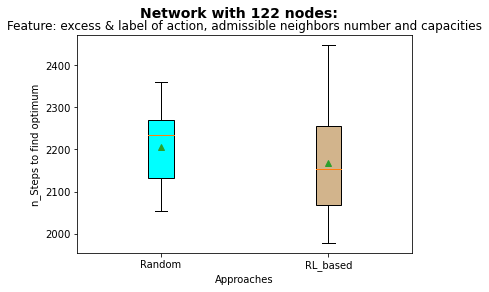

Rnadom Mean= 2206.181818181818 RL_based Mean= 2168.913043478261
Rnadom Median= 2234.0 RL_based Median= 2154.0


In [100]:

#1: Box Data

#Random Method:
opt_rand=np.array([2244,2224,2195,2276,2261,2056,2175,2273,2243,2359,2304,2108,2288,2238,2055,
                   2120,2091,2173,2230,2263,2293,2067])

opt_RL=[]
opt_RL.append(opt_steps[0])
for i in range(1,len(opt_steps)):
    opt_RL.append(opt_steps[i]-opt_steps[i-1])

box_data=[opt_rand,opt_RL]


#2: Box Plot:

fig = plt.figure()
fig.suptitle('Network with 122 nodes:', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
box=ax.boxplot(box_data,patch_artist=True,labels=['Random','RL_based'],showmeans=True)

ax.set_title('Feature: excess & label of action, admissible neighbors number and capacities')
ax.set_xlabel('Approaches')
ax.set_ylabel('n_Steps to find optimum')

#colors = ['cyan', 'lightblue', 'lightgreen', 'tan']

colors = ['cyan', 'tan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
plt.show()

print("Rnadom Mean=",np.mean(opt_rand),"RL_based Mean=",np.mean(opt_RL))

print("Rnadom Median=",np.median(opt_rand),"RL_based Median=",np.median(opt_RL))


In [81]:
n_neurons

12

In [97]:
opt_steps

[2016,
 4265,
 6468,
 8622,
 10640,
 12794,
 15173,
 17302,
 19337,
 21467,
 23914,
 26208,
 28322,
 30323,
 32301,
 34458,
 36778,
 39118,
 41314,
 43416,
 45678,
 47663,
 49885]

### Max Flow Algorithms: Edmonds Karp

In [67]:
from networkx.algorithms.flow import edmonds_karp
#start_time = time()

result = edmonds_karp(G, 0, 121,capacity='weight')
flow_value2= nx.maximum_flow_value(G, 0, 121,capacity='weight')
print("optimal flow from edmonds_karp algorithm is:",flow_value2)

for g in G.edges():
    print("flow of",g," is :",result[g[0]][g[1]]['flow'])

#process_time=time()-start_time
#print("process_time=",process_time)

optimal flow from edmonds_karp algorithm is: 995.0
flow of (0, 10)  is : 86.0
flow of (0, 9)  is : 119.0
flow of (0, 8)  is : 140.0
flow of (0, 7)  is : 105.0
flow of (0, 6)  is : 32.0
flow of (0, 5)  is : 35.0
flow of (0, 4)  is : 183.0
flow of (0, 3)  is : 113.0
flow of (0, 2)  is : 178.0
flow of (0, 1)  is : 4.0
flow of (10, 11)  is : 41.0
flow of (10, 20)  is : 18.0
flow of (10, 19)  is : 27.0
flow of (9, 20)  is : 69.0
flow of (9, 19)  is : 45.0
flow of (9, 18)  is : 5.0
flow of (8, 19)  is : 42.0
flow of (8, 18)  is : 25.0
flow of (8, 17)  is : 73.0
flow of (7, 18)  is : 8.0
flow of (7, 17)  is : 52.0
flow of (7, 16)  is : 45.0
flow of (6, 17)  is : 9.0
flow of (6, 16)  is : 1.0
flow of (6, 15)  is : 22.0
flow of (5, 16)  is : 0
flow of (5, 15)  is : 13.0
flow of (5, 14)  is : 22.0
flow of (4, 15)  is : 84.0
flow of (4, 14)  is : 53.0
flow of (4, 13)  is : 46.0
flow of (3, 14)  is : 14.0
flow of (3, 13)  is : 7.0
flow of (3, 12)  is : 92.0
flow of (2, 13)  is : 58.0
flow of (2, 1

flow of (95, 104)  is : 30.0
flow of (96, 107)  is : 21.0
flow of (96, 106)  is : 1.0
flow of (96, 105)  is : 16.0
flow of (97, 108)  is : 14.0
flow of (97, 107)  is : 38.0
flow of (97, 106)  is : 9.0
flow of (98, 109)  is : 2.0
flow of (98, 108)  is : 56.0
flow of (98, 107)  is : 56.0
flow of (99, 110)  is : 22.0
flow of (99, 109)  is : 48.0
flow of (99, 108)  is : 0
flow of (102, 113)  is : 11.0
flow of (102, 112)  is : 16.0
flow of (102, 111)  is : 78.0
flow of (101, 112)  is : 95.0
flow of (101, 111)  is : 64.0
flow of (101, 120)  is : 0
flow of (110, 111)  is : 33.0
flow of (110, 120)  is : 25.0
flow of (110, 119)  is : 0
flow of (103, 114)  is : 11.0
flow of (103, 113)  is : 44.0
flow of (103, 112)  is : 100.0
flow of (104, 115)  is : 25.0
flow of (104, 114)  is : 56.0
flow of (104, 113)  is : 56.0
flow of (105, 116)  is : 30.0
flow of (105, 115)  is : 69.0
flow of (105, 114)  is : 16.0
flow of (106, 117)  is : 11.0
flow of (106, 116)  is : 0
flow of (106, 115)  is : 9.0
flow of 

In [68]:
from networkx.algorithms.flow import shortest_augmenting_path
result2 = shortest_augmenting_path(G, 0, 121,capacity='weight')
flow_value3 = nx.maximum_flow_value(G, 0, 121,capacity='weight')
print("optimal flow from shortest_augmenting_path algorithm is:",flow_value3)

for g in G.edges():
    print("flow of",g," is :",result2[g[0]][g[1]]['flow'])

optimal flow from shortest_augmenting_path algorithm is: 995.0
flow of (0, 10)  is : 86.0
flow of (0, 9)  is : 119.0
flow of (0, 8)  is : 140.0
flow of (0, 7)  is : 105.0
flow of (0, 6)  is : 32.0
flow of (0, 5)  is : 35.0
flow of (0, 4)  is : 183.0
flow of (0, 3)  is : 113.0
flow of (0, 2)  is : 178.0
flow of (0, 1)  is : 4.0
flow of (10, 11)  is : 41.0
flow of (10, 20)  is : 18.0
flow of (10, 19)  is : 27.0
flow of (9, 20)  is : 69.0
flow of (9, 19)  is : 45.0
flow of (9, 18)  is : 5.0
flow of (8, 19)  is : 42.0
flow of (8, 18)  is : 25.0
flow of (8, 17)  is : 73.0
flow of (7, 18)  is : 8.0
flow of (7, 17)  is : 52.0
flow of (7, 16)  is : 45.0
flow of (6, 17)  is : 9.0
flow of (6, 16)  is : 1.0
flow of (6, 15)  is : 22.0
flow of (5, 16)  is : 0
flow of (5, 15)  is : 13.0
flow of (5, 14)  is : 22.0
flow of (4, 15)  is : 84.0
flow of (4, 14)  is : 53.0
flow of (4, 13)  is : 46.0
flow of (3, 14)  is : 14.0
flow of (3, 13)  is : 7.0
flow of (3, 12)  is : 92.0
flow of (2, 13)  is : 58.0
f

flow of (103, 113)  is : 91.0
flow of (103, 112)  is : 17.0
flow of (104, 115)  is : 25.0
flow of (104, 114)  is : 63.0
flow of (104, 113)  is : 56.0
flow of (105, 116)  is : 30.0
flow of (105, 115)  is : 76.0
flow of (105, 114)  is : 0
flow of (106, 117)  is : 36.0
flow of (106, 116)  is : 0
flow of (106, 115)  is : 0
flow of (107, 118)  is : 53.0
flow of (107, 117)  is : 18.0
flow of (107, 116)  is : 0
flow of (108, 119)  is : 60.0
flow of (108, 118)  is : 1.0
flow of (108, 117)  is : 31.0
flow of (109, 120)  is : 46.0
flow of (109, 119)  is : 6.0
flow of (109, 118)  is : 47.0
flow of (112, 121)  is : 125.0
flow of (111, 121)  is : 51.0
flow of (120, 121)  is : 71.0
flow of (113, 121)  is : 218.0
flow of (114, 121)  is : 147.0
flow of (115, 121)  is : 101.0
flow of (116, 121)  is : 30.0
flow of (117, 121)  is : 85.0
flow of (118, 121)  is : 101.0
flow of (119, 121)  is : 66.0
